# Python Library Import

In [1]:
import os
import glob
import numpy as np 
import pandas as pd 
import random
from os import listdir
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
import imutils    

from tensorflow.keras.models import Model,load_model
from tensorflow.keras.layers import Conv2D,Input,ZeroPadding2D,BatchNormalization,Flatten,Activation,Dense,MaxPooling2D
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from keras.preprocessing import image
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.layers import Input, Dense, Activation, BatchNormalization, Flatten, Conv2D
from keras.layers import MaxPooling2D, Dropout, UpSampling2D


In [2]:
from google.colab import drive

In [3]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Images Directory 

In [4]:
image_dir="/content/drive/MyDrive/BrainTumorDatasets"

image_dir

'/content/drive/MyDrive/BrainTumorDatasets'

In [5]:
path = os.path.join(image_dir, 'no/')
img_loc = random.choice(os.listdir(path))
img = cv2.imread(os.path.join(path, img_loc))
print('Shape of Image:',img.shape)

Shape of Image: (236, 212, 3)


______Healthy Brain Images______


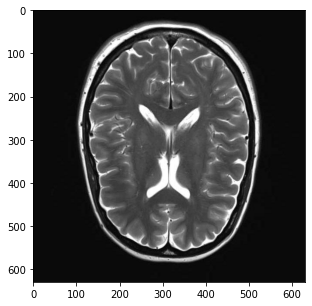

In [6]:
print('______Healthy Brain Images______')
plt.figure(figsize=(20,5))
img = cv2.imread('/content/drive/MyDrive/BrainTumorDatasets/no/No12.jpg', 0)
plt.imshow(img, cmap='gray')

In [7]:
path = os.path.join(image_dir, 'yes/')
img_loc = random.choice(os.listdir(path))
img = cv2.imread(os.path.join(path, img_loc))
print('Shape of Image:',img.shape)

Shape of Image: (630, 504, 3)


______Tumor Brain Images______
Shape of Image: (360, 319, 3)


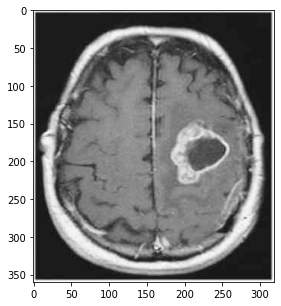

In [8]:
print('______Tumor Brain Images______')
plt.figure(figsize=(20,5))
img = cv2.imread('/content/drive/MyDrive/BrainTumorDatasets/yes/y1431.jpg', 1)
plt.imshow(img, cmap='gray')
print('Shape of Image:', img.shape)

In [9]:
Yes_IMAGES = glob.glob('/content/drive/MyDrive/BrainTumorDatasets/yes/*.jpg')
No_IMAGES = glob.glob('/content/drive/MyDrive/BrainTumorDatasets/no/*.jpg')

In [10]:
def load_image(path):
    image_list = np.zeros((len(path), 224,224, 1))
    for i, fig in enumerate(path):
        img = image.load_img(fig, color_mode='grayscale', target_size=(224, 224))
        x = image.img_to_array(img).astype('float32')
        x = x / 255.0
        image_list[i] = x
    
    return image_list

 **Splitting Images** 

In [11]:
x_train = load_image(Yes_IMAGES)
y_train = load_image(Yes_IMAGES)
x_test = load_image(No_IMAGES)
y_test = load_image(No_IMAGES)
print(x_train.shape, x_test.shape)

(1500, 224, 224, 1) (1895, 224, 224, 1)


In [12]:
def train_val_split(x_train, y_train):
    rnd = np.random.RandomState(seed=42)
    perm = rnd.permutation(len(x_train))
    train_id = perm[:int(0.8 * len(x_train))]
    val_id = perm[int(0.8 * len(x_train)):]
    return x_train[train_id], y_train[train_id], x_train[val_id], y_train[val_id]

x_train, y_train, x_val, y_val = train_val_split(x_train, y_train)
print(x_train.shape, x_val.shape)

(1200, 224, 224, 1) (300, 224, 224, 1)


 **Training Model**

In [13]:
class Autoencoder():
    def __init__(self):
        self.img_rows = 224
        self.img_cols = 224
        self.channels = 1
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        
        optimizer = Adam(lr=0.001)
        
        self.autoencoder_model = self.build_model()
        self.autoencoder_model.compile(loss='mse', optimizer=optimizer)
        self.autoencoder_model.summary()
    
    def build_model(self):
        input_layer = Input(shape=self.img_shape)
        
        # encoder
        h = Conv2D(64, (3, 3), activation='relu', padding='same')(input_layer)
        h = MaxPooling2D((2, 2), padding='same')(h)
        
        # decoder
        h = Conv2D(64, (3, 3), activation='relu', padding='same')(h)
        h = UpSampling2D((2, 2))(h)
        output_layer = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(h)
        
        return Model(input_layer, output_layer)
    
    def train_model(self, x_train, y_train, x_val, y_val, epochs, batch_size=20):
        
        early_stopping = EarlyStopping(monitor='val_loss', 
                                       min_delta=0,
                                       patience=5,
                                       verbose=1, 
                                       mode='auto')
        history = self.autoencoder_model.fit(x_train, y_train,
                                             batch_size=batch_size,
                                             epochs=epochs,
                                             validation_data=(x_val, y_val),
                                             callbacks=[early_stopping])


        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('Model loss')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Valid'], loc='upper left')
        plt.show()
    
    def eval_model(self, x_test):
        preds = self.autoencoder_model.predict(x_test)
        return preds


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 224, 224, 64)      640       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 64)      36928     
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 224, 224, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 224, 224, 1)       577       
Total params: 38,145
Trainable params: 38,145
Non-trainable params: 0
_________________________________________________________

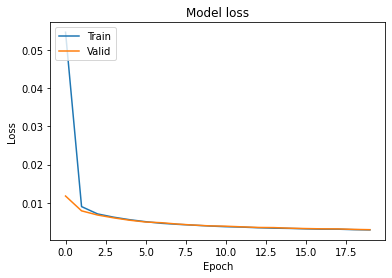

In [14]:
ae = Autoencoder()
ae.train_model(x_train, y_train, x_val, y_val, epochs=20, batch_size=30)

In [15]:
preds = ae.eval_model(x_test)

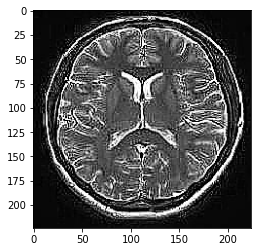

In [16]:
preds_0 = preds[10] * 255.0
preds_0 = preds_0.reshape(224, 224)
x_test_0 = x_test[10] * 255.0
x_test_0 = x_test_0.reshape(224, 224)
plt.imshow(x_test_0, cmap='gray')

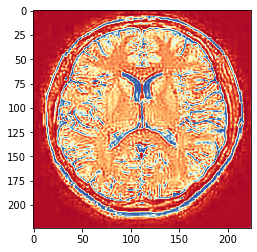

In [17]:
plt.imshow(preds_0, cmap='RdYlBu')

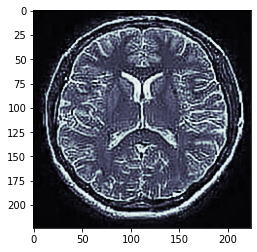

In [18]:
plt.imshow(preds_0, cmap='bone')

In [19]:
preds = preds.reshape(-1, 224, 224)

In [20]:
preds

array([[[0.06426322, 0.02954346, 0.02480616, ..., 0.02489754,
         0.03238756, 0.07797769],
        [0.0264853 , 0.00997223, 0.00909025, ..., 0.00905693,
         0.01191808, 0.03997476],
        [0.02115427, 0.00923926, 0.01006011, ..., 0.0099074 ,
         0.01159219, 0.03458013],
        ...,
        [0.02174911, 0.00937014, 0.01009692, ..., 0.0105983 ,
         0.01249835, 0.0372781 ],
        [0.02994526, 0.0116467 , 0.01099577, ..., 0.01133162,
         0.01474292, 0.04698756],
        [0.07728931, 0.03679114, 0.03157287, ..., 0.03157301,
         0.04076049, 0.11178148]],

       [[0.06643099, 0.03136772, 0.02713712, ..., 0.02685259,
         0.03424526, 0.08059446],
        [0.02820118, 0.0109278 , 0.01023368, ..., 0.01013711,
         0.0129728 , 0.04209655],
        [0.02292899, 0.01026006, 0.01144498, ..., 0.01128987,
         0.01281417, 0.03687297],
        ...,
        [0.02495427, 0.01153856, 0.0127092 , ..., 0.01253601,
         0.01430551, 0.04099938],
        [0.0

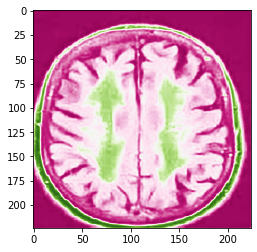

In [21]:
preds_1 = preds[20] * 255.0
preds_1 = preds_1.reshape(224, 224)

plt.imshow(preds_1, cmap='PiYG')

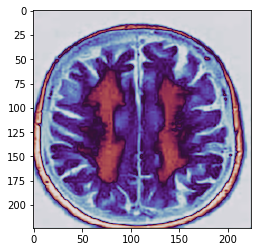

In [22]:
preds_2 = preds[50] * 255.0
preds_2 = preds_2.reshape(224, 224)

plt.imshow(preds_1, cmap='twilight')